In [1]:
# this file will:
    #1. load data
    #2. data augmentation
    #3. preprocess (scaling on label)
    #4. training the network on training data(use DL notebook from w4)
    #5. test (use DL notebook from w4)

In [13]:
# Import cell
import torch
import torch.nn as nn
import math
import numpy as np
from collections import OrderedDict

import torchvision.transforms as transforms
import torchvision
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import seaborn as sns

# image loading
import os
from PIL import Image

# training process
from sklearn import model_selection

import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim

from sklearn import metrics

import random #for data shuffling in list

#torch.optim.lr_scheduler

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
################## DATA LOADERS ###############
def read_img(root, filedir, transform=None):
    # Data loading
    with open(filedir, 'r') as f:
        lines = f.readlines()  
    output = []    
    for line in lines:
        linesplit = line.split('\n')[0].split(' ')
        #print(linesplit)
        addr = linesplit[0]
        target = torch.Tensor([float(linesplit[1])])
        img = Image.open(os.path.join(root, addr)).convert('RGB')

        if transform is not None:
            img = transform(img)
        
        output.append([img, target])

    return output


################## DATA ANALYSIS ###############
def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()
        
################## PERFORMANCE ANALYSIS ###############      
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

In [16]:
################## AlexNet ##################
def bn_relu(inplanes):
    return nn.Sequential(nn.BatchNorm2d(inplanes), nn.ReLU(inplace=True))

def bn_relu_pool(inplanes, kernel_size=3, stride=2):
    return nn.Sequential(nn.BatchNorm2d(inplanes), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=kernel_size, stride=stride))

class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, bias=False)
        self.relu_pool1 = bn_relu_pool(inplanes=96)
        self.conv2 = nn.Conv2d(96, 192, kernel_size=5, padding=2, groups=2, bias=False)
        self.relu_pool2 = bn_relu_pool(inplanes=192)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu3 = bn_relu(inplanes=384)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu4 = bn_relu(inplanes=384)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu_pool5 = bn_relu_pool(inplanes=256)
        # classifier
        self.conv6 = nn.Conv2d(256, 256, kernel_size=5, groups=2, bias=False)
        self.relu6 = bn_relu(inplanes=256)
        self.conv7 = nn.Conv2d(256, num_classes, kernel_size=1, bias=False)
        
        # Dropout
        #self.dropout = nn.Dropout(p=0.2)
        
        # Batchnorm
        #self.batchnorm = nn.BatchNorm2d(num_features=256)
        
        #self.batchnorm_1 = nn.BatchNorm2d(num_features=192)
        
        #self.batchnorm_2 = nn.BatchNorm2d(num_features=384)

    def forward(self, x):
        x = self.conv1(x)
       # x = self.dropout(x)
        x = self.relu_pool1(x)
        x = self.conv2(x)
       # x = self.dropout(x)
        #x = self.batchnorm_1(x)
        x = self.relu_pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        #x = self.batchnorm_2(x)
      #  x = self.dropout(x)
        x = self.conv4(x)
        
        x = self.relu4(x)
        #x = self.batchnorm_2(x)
        x = self.conv5(x)
        x = self.relu_pool5(x)
        #x = self.batchnorm(x)
        x = self.conv6(x)
        x = self.relu6(x)
        #x = self.batchnorm(x)
        x = self.conv7(x)
        x = x.view(x.size(0), -1)
        return x

In [17]:
# Scaling of data
#file_in = './data/1/morph_all_label.txt'
file_in = 'image_label_mapping.txt'
mylines = []                             # Declare an empty list named mylines.
with open(file_in, 'rt') as myfile: # Open lorem.txt for reading text data.
    for myline in myfile:                # For each line, stored as myline,
        mylines.append(float(myline.split()[1]))       # add its contents to mylines.

min_val = min(mylines)
max_val = max(mylines)
lower_scale = 0
upper_scale = 4

for i in range(len(mylines)):
    mylines[i] = int(np.round(((upper_scale-lower_scale)*((mylines[i]-min_val)/(max_val-min_val)))+lower_scale))
    
print(mylines.count(0))
print(mylines.count(1))
print(mylines.count(2))
print(mylines.count(3))
print(mylines.count(4))

392
700
1120
1288
476


In [18]:
# Storing scaled data to images
file_out = 'image_label_mapping_scaled.txt'

cntr = 0
with open(file_in, 'r') as f_in:
    with open(file_out, 'w') as f_out:
        for line in f_in:
            image_name = line.split()[0] + ' '
            rating = mylines[cntr]
            
            f_out.write(image_name+str(rating)+'\n')
            cntr+=1

In [19]:
#def main():
# net definition 
net = AlexNet()
device = torch.device('cpu')  # use cuda or cpu
net.to(device)

# evaluate
net.eval()

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), bias=False)
  (relu_pool1): Sequential(
    (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2, bias=False)
  (relu_pool2): Sequential(
    (0): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2, bias=False)
  (relu3): Sequential(
    (0): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
  )
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2, bias=False)
  (

In [20]:
root = 'C:/Users/Lenovo/Documents/AdvancedProject/NeuralNetwork/data/dataset'
valdir = 'image_label_mapping_scaled.txt'

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])  
data = read_img(root, valdir, transform=transform)


In [21]:
for i in range(len(data)):
    data[i][1] = int(data[i][1].numpy()[0])

In [22]:
for i, d in enumerate(data):
    data[i] = tuple(d)

In [23]:
random.shuffle(data)

In [24]:
train_count = int(0.8*len(data))
train_count

3180

In [25]:
# Train test split, we can also use tf.split() but it doesn't support percentage split??
train_set = data[:train_count]
test_set = data[train_count:len(data)]

In [26]:
type(train_set[0][0])

torch.Tensor

In [27]:
len(train_set)

3180

In [28]:
type(test_set[0][0])

torch.Tensor

In [29]:
batch_size = 32 # try this out for training

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)

In [30]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
#print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
#print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = 5
classes = list(range(5))
classes

Training data
Number of points: 3180
Batch dimension (B x C x H x W): torch.Size([32, 3, 224, 224])

Test data
Number of points: 796
Batch dimension (B x C x H x W): torch.Size([32, 3, 224, 224])


[0, 1, 2, 3, 4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


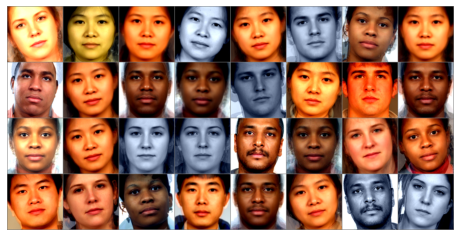

tensor([4, 2, 3, 2, 3, 4, 1, 3, 1, 4, 4, 4, 2, 1, 2, 2, 3, 4, 4, 3, 1, 3, 2, 3,
        1, 1, 4, 2, 3, 2, 1, 1])

In [31]:
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))
labels

In [32]:
# Define a loss function

loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [33]:
# Test the forward pass with dummy data
out = net(torch.randn(2, 3, 224, 224, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 5])
Output logits:
[[ 0.00880263 -0.00378168 -0.00177569  0.00150383 -0.00056551]
 [ 0.0091419  -0.00480515 -0.00239969 -0.00240655 -0.00026355]]
Output probabilities:
[[0.20159765 0.19907658 0.19947633 0.20013158 0.19971788]
 [0.20186396 0.1990681  0.19954751 0.19954614 0.19997424]]


In [34]:
num_epochs = 100
validation_every_steps = 100

step = 0
net.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    print(epoch)
    train_accuracies_batches = []
    print(len(train_loader))
    for inputs, targets in train_loader:
        #print('hér')
        inputs, targets = inputs.to(device), targets.to(device)
        
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!

        # Forward
        output = net(inputs)
        loss = loss_fn(output, targets)   
        
        # backward
        loss.backward()

        # optimize
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                net.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = net(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                net.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")
            
    scheduler.step()

print("Finished training.")

0
100
Step 100     training accuracy: 0.42072916666666665
             test accuracy: 0.2952261306532663
1
100
Step 200     training accuracy: 0.5367708333333333
             test accuracy: 0.4296482412060301
2
100
Step 300     training accuracy: 0.6566666666666667
             test accuracy: 0.6293969849246231
3
100
Step 400     training accuracy: 0.7473958333333333
             test accuracy: 0.7211055276381909
4
100
Step 500     training accuracy: 0.8321875
             test accuracy: 0.8052763819095478
5
100
Step 600     training accuracy: 0.8785416666666667
             test accuracy: 0.8517587939698492
6
100
Step 700     training accuracy: 0.9079166666666667
             test accuracy: 0.8442211055276382
7
100
Step 800     training accuracy: 0.9426041666666667
             test accuracy: 0.914572864321608
8
100
Step 900     training accuracy: 0.9528125
             test accuracy: 0.8919597989949749
9
100
Step 1000    training accuracy: 0.9671875
             test accuracy: 0.9195

Step 8600    training accuracy: 0.996875
             test accuracy: 0.9685929648241206
86
100
Step 8700    training accuracy: 0.9965625
             test accuracy: 0.9660804020100503
87
100
Step 8800    training accuracy: 0.9965625
             test accuracy: 0.9623115577889447
88
100
Step 8900    training accuracy: 0.9959375
             test accuracy: 0.957286432160804
89
100
Step 9000    training accuracy: 0.9975
             test accuracy: 0.9685929648241206
90
100
Step 9100    training accuracy: 0.9965625
             test accuracy: 0.9597989949748744
91
100
Step 9200    training accuracy: 0.9966666666666667
             test accuracy: 0.9660804020100503
92
100
Step 9300    training accuracy: 0.9965625
             test accuracy: 0.964824120603015
93
100
Step 9400    training accuracy: 0.9953125
             test accuracy: 0.964824120603015
94
100
Step 9500    training accuracy: 0.996875
             test accuracy: 0.9660804020100503
95
100
Step 9600    training accuracy: 0.99375

In [35]:
torch.save(net.state_dict(), './pytorch-models/cnn_ADAM_schlr.pth')

In [36]:
valid_accuracies

[0.2952261306532663,
 0.4296482412060301,
 0.6293969849246231,
 0.7211055276381909,
 0.8052763819095478,
 0.8517587939698492,
 0.8442211055276382,
 0.914572864321608,
 0.8919597989949749,
 0.9195979899497487,
 0.9459798994974874,
 0.949748743718593,
 0.9447236180904522,
 0.9346733668341709,
 0.9447236180904522,
 0.9623115577889447,
 0.9585427135678392,
 0.9597989949748744,
 0.9635678391959799,
 0.9610552763819096,
 0.9610552763819096,
 0.9597989949748744,
 0.9522613065326633,
 0.9597989949748744,
 0.9610552763819096,
 0.9623115577889447,
 0.9660804020100503,
 0.9610552763819096,
 0.9660804020100503,
 0.964824120603015,
 0.9635678391959799,
 0.9673366834170855,
 0.9635678391959799,
 0.964824120603015,
 0.9597989949748744,
 0.9685929648241206,
 0.964824120603015,
 0.964824120603015,
 0.9635678391959799,
 0.9660804020100503,
 0.9635678391959799,
 0.964824120603015,
 0.9610552763819096,
 0.9585427135678392,
 0.9660804020100503,
 0.9660804020100503,
 0.9673366834170855,
 0.964824120603015,


In [37]:
train_accuracies

[0.42072916666666665,
 0.5367708333333333,
 0.6566666666666667,
 0.7473958333333333,
 0.8321875,
 0.8785416666666667,
 0.9079166666666667,
 0.9426041666666667,
 0.9528125,
 0.9671875,
 0.97625,
 0.9841666666666667,
 0.9809375,
 0.9879166666666667,
 0.990625,
 0.9919791666666667,
 0.9873958333333333,
 0.9913541666666668,
 0.9940625,
 0.994375,
 0.99375,
 0.994375,
 0.995625,
 0.9940625,
 0.995,
 0.9959375,
 0.99625,
 0.995625,
 0.9953125,
 0.994375,
 0.995,
 0.995,
 0.995625,
 0.9946875,
 0.9965625,
 0.99625,
 0.995625,
 0.995,
 0.9953125,
 0.9942708333333333,
 0.995625,
 0.9959375,
 0.9959375,
 0.995,
 0.9963541666666668,
 0.9965625,
 0.9965625,
 0.9940625,
 0.9975,
 0.99625,
 0.995625,
 0.9959375,
 0.996875,
 0.9959375,
 0.99625,
 0.9971875,
 0.9941666666666668,
 0.9971875,
 0.9978125,
 0.9965625,
 0.99625,
 0.9965625,
 0.99625,
 0.9965625,
 0.99625,
 0.9959375,
 0.99625,
 0.9984375,
 0.9984375,
 0.9965625,
 0.994375,
 0.9953125,
 0.9971875,
 0.996875,
 0.996875,
 0.9953125,
 0.996875

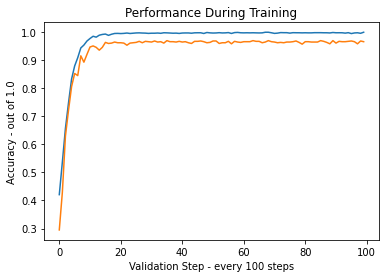

In [38]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_accuracies)),train_accuracies, label = 'Train Accuracy')
plt.plot(range(len(train_accuracies)),valid_accuracies, label = 'Test Accuracy')
plt.xlabel('Validation Step - every 100 steps')
plt.ylabel('Accuracy - out of 1.0')
plt.title("Performance During Training")
plt.savefig('train_test_acc_100epoch_ADAM_schlr.jpg')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


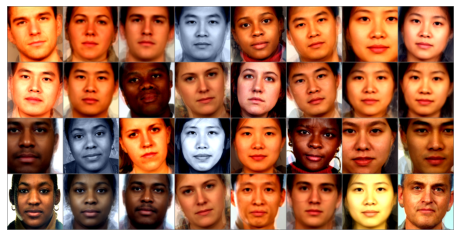

    TRUE        PREDICTED
-----------------------------
      1             1      
      2             2      
      3             3      
      3             3      
      3             3      
      3             3      
      4             4      
      4             4      
      2             2      
      3             3      
      1             1      
      2             2      
      1             1      
      2             2      
      2             2      
      3             3      
      3             3      
      2             2      
      0             0      
      0             0      
      3             3      
      1             1      
      1             1      
      2             2      
      2             2      
      4             4      
      2             2      
      2             2      
      0             0      
      3             3      
      4             4      
      2             2      


In [39]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = net(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")

In [40]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    net.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = net(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]
        
        print(target, predictions)
        
        if compute_confusion_matrix(targets, predictions, 'true').shape == (5, 5):
        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
            test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
            confusion_matrix += compute_confusion_matrix(targets, predictions, 'true')

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    net.train()

tensor(2) tensor([4, 4, 3, 3, 2, 1, 2, 2, 1, 3, 4, 3, 4, 1, 4, 2, 3, 2, 2, 3, 4, 2, 1, 0,
        3, 2, 2, 2, 1, 3, 1, 2])
tensor(2) tensor([1, 3, 2, 2, 2, 3, 1, 3, 3, 1, 3, 0, 4, 3, 3, 2, 3, 3, 1, 2, 1, 0, 1, 3,
        2, 4, 2, 2, 3, 3, 0, 4])
tensor(2) tensor([2, 1, 0, 1, 1, 1, 0, 2, 4, 2, 1, 2, 4, 3, 2, 2, 1, 1, 3, 3, 0, 3, 0, 1,
        2, 4, 2, 4, 1, 4, 2, 3])
tensor(2) tensor([1, 3, 4, 1, 4, 3, 1, 3, 0, 3, 4, 2, 3, 3, 3, 2, 3, 2, 1, 3, 4, 3, 2, 3,
        2, 3, 4, 0, 1, 3, 2, 3])
tensor(2) tensor([2, 2, 3, 2, 4, 3, 3, 2, 2, 1, 2, 3, 4, 3, 2, 1, 2, 3, 2, 3, 3, 3, 2, 1,
        1, 3, 1, 3, 3, 4, 2, 3])
tensor(2) tensor([4, 1, 3, 4, 3, 0, 1, 4, 2, 1, 3, 3, 3, 4, 1, 3, 4, 0, 2, 0, 3, 3, 3, 2,
        2, 3, 2, 4, 3, 2, 3, 2])
tensor(2) tensor([2, 2, 3, 4, 3, 2, 3, 2, 3, 3, 0, 3, 3, 3, 2, 2, 2, 3, 1, 2, 1, 3, 3, 3,
        2, 4, 3, 2, 3, 3, 4, 3])
tensor(2) tensor([1, 1, 2, 3, 4, 3, 3, 3, 3, 4, 3, 0, 2, 1, 3, 2, 4, 3, 4, 1, 1, 3, 4, 3,
        0, 3, 0, 0, 1, 2, 4, 4])
tensor(2) tensor

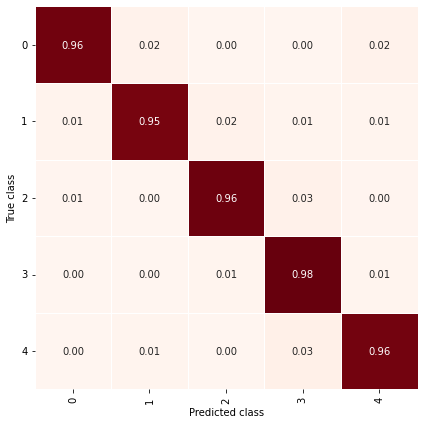

In [41]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()

plt.savefig('conf_matrix_100epoch_ADAM_schlr.jpg')
plt.show()

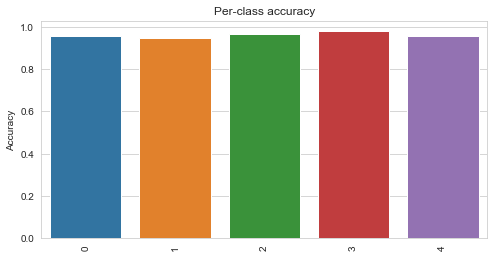

In [42]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.savefig('class_prob_100epoch_SGD_DropOut.jpg')
    plt.show()